In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import os 
sns.set_style('whitegrid')

import string
from datetime import datetime
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+') # initialize regex tokenizer
exclude = set(string.punctuation)
en_stop = set(stopwords.words('english'))# create English stop words list
lemma = WordNetLemmatizer()
p_stemmer = PorterStemmer() # Create p_stemmer of class PorterStemmer

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for raw in doc_set:
        # clean and tokenize document string
        tokens = tokenizer.tokenize(raw.lower())
        # remove stop words and unwanted words from tokens
        stopped_tokens = [i for i in tokens if (i not in en_stop) and (i not in exclude)]
        # stem tokens
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
def show_section_name(document_list):
    return [[k[0] for k in i] for i in document_list]

def show_unique_section_name(document_list):
    result = {}
    for i in document_list:
        for k in i:
            if k[0] not in result:
                result[k[0]]=1
            else:
                result[k[0]]+=1
    return {k: v for k, v in sorted(result.items(), key=lambda item: -item[1])}



def rule_for_merge(list_of_names,target_name,document_list):
    new_document_list = document_list.copy()
    list_of_names = list_of_names+[target_name]
    for n,document in enumerate(document_list):
        new_document = []
        merged_paragraph = [target_name]
        for paragraph in document:
            if paragraph[0] not in list_of_names:
                new_document.append(paragraph)
            else:
                merged_paragraph = merged_paragraph + paragraph[1:]
        if merged_paragraph!=[target_name]:
            new_document.append(merged_paragraph)
        new_document_list[n] = new_document
    return new_document_list

def rule_for_replace(dict1,document_list):
    for orignal_name in dict1.keys():
        target_name = dict1[orignal_name]
        for n,document in enumerate(document_list):
            for k,paragraph in enumerate(document):
                if paragraph[0] == orignal_name:
                    document_list[n][k][0]= target_name
    return document_list


def encode_doc_minutes(Document_list):
    return '##NewTopic##'.join(['##NewPara##'.join(i) for i in Document_list])

def decode_doc_minutes(Doc_string):
    return [i.split('##NewPara##') for i in Doc_string.split('##NewTopic##')]

def load_up_from_cleaned_minutes():
    MPC_minutes = pd.read_excel('./scripter/cleaned_dataset/MPC_minutes.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Minutes_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Minutes_MPC/{}".format(file), "r").read()
        MPC_minutes.loc[MPC_minutes['title']==file[:-4],'document_string'] = text_file
    return MPC_minutes

def write_file(Document_list,folder,file):
    Word_set = encode_doc_minutes(Document_list)
    text_file = open("./scripter/cleaned_dataset/{}/{}.txt".format(folder,file[:-5]), "w")
    text_file.write(Word_set)
    text_file.close()    
    return None

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lunarhero\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 3: create topical dictionary sentiments

In [268]:
def load_interest_rate():
    data_list = []
    for i in ['LIBOR_1M.csv','LIBOR_1Y.csv','LIBOR_3M.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.columns = [i[:-4]]
        data_list.append(df)
    libor_rate = pd.concat(data_list,axis=1).dropna()
    for i in range(3):
        libor_rate.iloc[:,i] = libor_rate.iloc[:,i].astype(float).round(4)
        
    data_list = []
    for i in ['interbank_sonia.csv','interbank_1M.csv','interbank_1Y.csv','Euro_currency_offered_rates_USD.csv','Euro_currency_offered_rates_EUR.csv']:
        df = pd.read_csv('./scripter/cleaned_dataset/{}'.format(i),index_col = 0)
        df.index = pd.DatetimeIndex(df.index)+pd.offsets.MonthBegin(0)
        df.columns = [i[:-4]]
        data_list.append(df)
    sonia_rate = data_list[0].join(data_list[1]).join(data_list[2]).join(data_list[3]).join(data_list[4])
    merged_dataset = libor_rate.join(sonia_rate,how='outer')
    items = list(merged_dataset)
    merged_dataset = merged_dataset.loc[merged_dataset.index>'1997-01-01',:]
    return merged_dataset

def create_label_for_dictionary(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]
    threshold = 0.1
    for i in range(12,len(rate_change)-12):
        if list_of_value[i]-list_of_value[i+12]>threshold:
            rate_change[i] = -1
            plot_negative[i] = list_of_value[i]
        elif list_of_value[i]-list_of_value[i+12]<-threshold:
            rate_change[i] = 1
            plot_positive[i] = list_of_value[i]
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change

def create_label_for_dictionary_2(list_of_value,date_range):
    date_range = merged_dataset.index
    if list_of_value[-1] == np.nan:
        list_of_value[-1] = list_of_value[-2]
    plot_positive = [np.nan for i in list_of_value]
    plot_negative = [np.nan for i in list_of_value]

    rate_change = [0 for i in list_of_value]

    N = len(rate_change)
    for i in range(0,N-8):
        for k in range(7):
            if list_of_value[i+k] == list_of_value[i+k+1]:
                pass
            elif list_of_value[i+k] > list_of_value[i+k+1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]
                break
            elif list_of_value[i+k] < list_of_value[i+k+1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i]
                break
        if rate_change[i] == 0 and i>=1:
            if list_of_value[i] > list_of_value[i-1]:
                rate_change[i] = 1
                plot_positive[i] = list_of_value[i] 
            elif list_of_value[i] < list_of_value[i-1]:
                rate_change[i] = -1
                plot_negative[i] = list_of_value[i]                
    plt.figure(figsize=(10,5),dpi=120)
    plt.plot(date_range,list_of_value,color='#757575')
    plt.plot(date_range,plot_positive,color='#42bdb9',lw=3,label='positive label')
    plt.plot(date_range,plot_negative,color='#ef6565',lw=3,label='negatove label')
    plt.legend()
    return rate_change

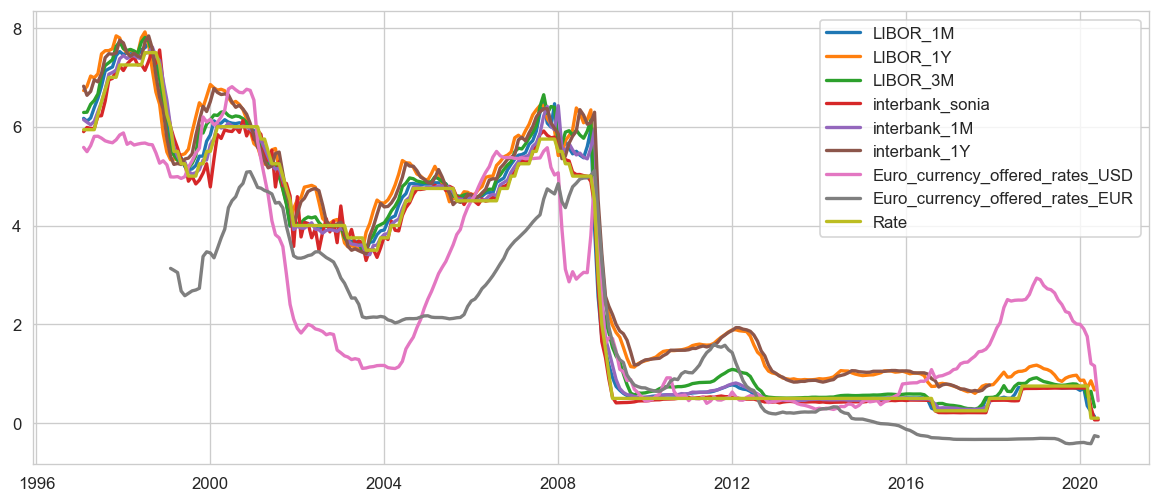

In [3]:
merged_dataset = load_interest_rate()

base_rate = pd.read_csv('./scripter/cleaned_dataset/Bank Rate  Bank of England Database.csv',index_col = 0)
base_rate.index = pd.DatetimeIndex(base_rate.index)
base_rate = base_rate.reindex(pd.date_range(start = base_rate.index[-1], end = merged_dataset.index[-1]))
for i in range(1,len(base_rate)):
    if base_rate.iloc[i,0]!=base_rate.iloc[i,0]:
        base_rate.iloc[i,0]=base_rate.iloc[i-1,0]
merged_dataset = merged_dataset.join(base_rate,how='inner')
items = list(merged_dataset)
plt.figure(figsize=(12,5),dpi=120)
for i in range(len(items)):
    plt.plot(merged_dataset.index,merged_dataset.iloc[:,i].values,label = items[i],lw=2)
plt.legend()
plt.show()

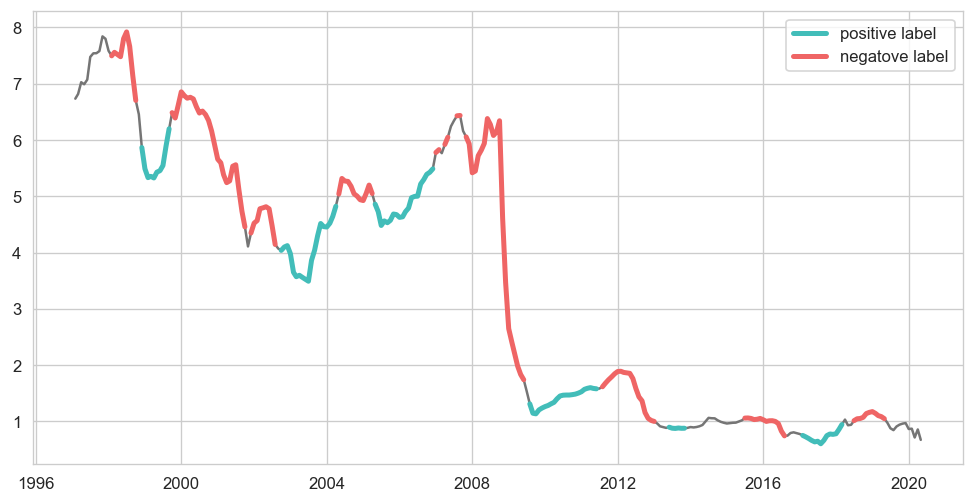

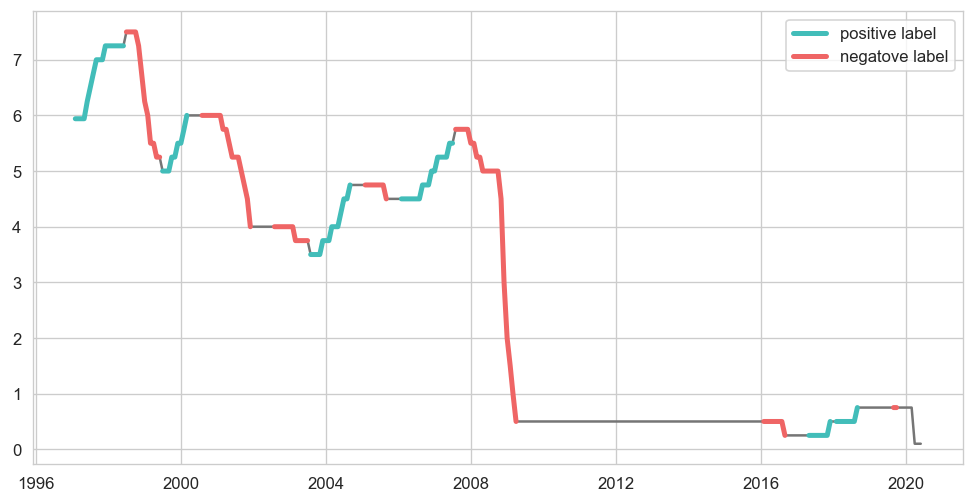

In [269]:
date_range = merged_dataset.index
list_of_value = merged_dataset.LIBOR_1Y.values
rate_change = create_label_for_dictionary(list_of_value,date_range)
date_range = merged_dataset.index
list_of_value_2 = merged_dataset.Rate.values
rate_change_2 = create_label_for_dictionary_2(list_of_value_2,date_range)

In [270]:
MPC_minutes = pd.read_hdf('data.h5', 'minutes')
minutes_timeseries = MPC_minutes.loc[:,['date','title','N_topics']]
minutes_timeseries = minutes_timeseries.set_index('date')
minutes_timeseries.index = pd.DatetimeIndex(minutes_timeseries.index)+pd.offsets.MonthBegin(0)

label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in minutes_timeseries.index]
minutes_timeseries.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in minutes_timeseries.index]
minutes_timeseries.loc[:,'label_2'] = label_list
minutes_timeseries.head()

title  \
date                                                            
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-04-01       Bank Rate maintained at 01% - March 2020_1st   
2020-04-01  Minutes of the special Monetary Policy Committ...   
2020-02-01    Bank Rate maintained at 075% - January 2020_1st   
2020-01-01   Bank Rate maintained at 075% - December 2019_1st   

                                                     N_topics  label  label_2  
date                                                                           
2020-06-01  [[Growth and inflation projections, Authoritie...      0        0  
2020-04-01  [[Growth and inflation projections, The Bank o...      0        0  
2020-04-01  [[Financial markets, Since the January MPC mee...      0        0  
2020-02-01  [[Growth and inflation projections, The Bank o...      0        0  
2020-01-01  [[Growth and inflation projections, The Bank o...      0        0

## Part 3.1 analysis performance accross different topics

In [259]:
def create_word_frequency(positve_rate_change):

    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}

    for doc in positve_rate_change.N_topics:
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            all_corpus['All'].append(preprocess_data(para[1:]))

    for i in topics:
        for corpus in all_corpus[i]:
            for sentence in corpus:
                for token in sentence:
                    if token not in wordfreq[i].keys():
                        wordfreq[i][token] = 1
                    else:
                        wordfreq[i][token] += 1
        wordfreq[i] = {k: v for k, v in sorted(wordfreq[i].items(), key=lambda item: -item[1])} # sorting
    return wordfreq

def create_doc_frequency(positve_rate_change):
    all_corpus = {i:[] for i in topics}
    wordfreq = {i:{} for i in topics}
    
    for doc in positve_rate_change.N_topics:
        document = []
        for para in doc:
            all_corpus[para[0]].append(preprocess_data(para[1:]))
            document += para[1:]
        all_corpus['All'].append(preprocess_data(document))

    for i in topics:
        for corpus in all_corpus[i]:
            seen_word = []
            for sentence in corpus:
                for token in sentence:
                    if token not in seen_word:
                        seen_word.append(token)
                        if token not in wordfreq[i].keys():
                            wordfreq[i][token] = 1
                        else:
                            wordfreq[i][token] += 1
    return wordfreq

def load_LM_dictionary():
    LM_dict = pd.read_excel('.\Dictionary_based_method\L&M dictioanry.xls').loc[:,['Entry','Positiv','Negativ','Econ@','ECON']]
    LM_dict = LM_dict.dropna(subset = ['Econ@','ECON'])
    LM_dict.loc[:,'sentiment'] = 'Neutral'
    LM_dict.loc[LM_dict.loc[:,'Positiv']=='Positiv','sentiment'] = 'Positive'
    LM_dict.loc[LM_dict.loc[:,'Negativ']=='Negativ','sentiment'] = 'Negative'
    LM_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in LM_dict.loc[:,'Entry'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]       
    LM_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True) 
    LM_dict = LM_dict.loc[:,['Entry','sentiment']]
    return LM_dict

def load_FS_dictionary():
    FS_dict = pd.read_excel('./Dictionary_based_method/Stability_dictionary.xlsx')
    FS_dict.loc[FS_dict.loc[:,'Positive']==1,'sentiment'] = 'Positive'
    FS_dict.loc[FS_dict.loc[:,'Negative']==1,'sentiment'] = 'Negative'
    FS_dict.loc[:,'Entry'] =  [lemma.lemmatize(p_stemmer.stem(re.sub('#[0-9]', '',i))) for i in FS_dict.loc[:,'Word'].apply(lambda x: x.lower()) if (i not in en_stop) and (i not in exclude)]    
    FS_dict = FS_dict.loc[:,['Entry','sentiment']]
    FS_dict.drop_duplicates(subset ='Entry', keep = "first", inplace = True)
    return FS_dict

def sentiment_calculator(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += ' '.join(para[1:])
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan

def find_frequency(word,dictionary,topic):
    if word in dictionary[topic].keys():
        return dictionary[topic][word]
    else:
        return 0


my_color = ['#ef6565','#42bdb9','#ffd000']
topics =[
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
    'All'
]


# def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
#     sentiment = []
#     word_list_all = word_list[topic]
#     word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
#     positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False).index
#     positive = list(positive)[:min(200,len(positive))]
#     sentiment += ['Positive' for i in enumerate(positive)]
#     negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False).index
#     negative = list(negative)[:min(200,len(negative))]
#     sentiment += ['Negative' for i in enumerate(negative)]
#     Entry = positive+negative
#     New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
#     return New_dictionary


def create_custom_dictionary(word_list,topic,para=[20,0.55,0.6]):
    sentiment = []
    FS_dict = load_FS_dictionary().set_index('Entry')
    word_list_all = word_list[topic]
    FS_dict = FS_dict.join(word_list_all,how='inner')
    word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
    
    positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'],ascending=False).index
    
    Positive = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Positive',:].loc[FS_dict.loc[:,'p percentage no neutral']>0.5,:].index
    positive = list(positive)[:min(100,len(positive))]+list(Positive)
    sentiment += ['Positive' for i in enumerate(positive)]
    
    negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'],ascending=False).index
    Negative = FS_dict.loc[FS_dict.loc[:,'sentiment']=='Negative',:].loc[FS_dict.loc[:,'n percentage no neutral']>0.5,:].index
    negative = list(negative)[:min(100,len(negative))]+list(Negative)
    sentiment += ['Negative' for i in enumerate(negative)]
    
    Entry = positive+negative
    New_dictionary = pd.DataFrame(data={'Entry':Entry,'sentiment':sentiment})
    return New_dictionary







def create_cooccurence_list(minutes_timeseries,label='label'):
    positve_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==1,:]
    negative_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==-1,:]
    neutral_rate_change = minutes_timeseries.loc[minutes_timeseries.loc[:,label]==0,:]
    print('Positive count:{}   Negative count:{}   Neutral count:{}'.format(len(positve_rate_change),len(negative_rate_change),len(neutral_rate_change)))
    print('calculate word frequency')
    postive_doc_freq = create_doc_frequency(positve_rate_change)
    negative_doc_freq = create_doc_frequency(negative_rate_change)
    neutral_doc_freq = create_doc_frequency(neutral_rate_change)

    multiplier = len(positve_rate_change)/len(negative_rate_change)
    multiplier_ne = len(neutral_rate_change)/len(negative_rate_change)
    result = {}
    for topic in topics:
        print('create dictionary for topic: '+topic)
        doc_count_df = pd.DataFrame(index = negative_doc_freq[topic].keys(),data={'negative count':list(negative_doc_freq[topic].values())
            }).join(
                pd.DataFrame(index=postive_doc_freq[topic].keys(),data={'postive count':[int(i/multiplier) for i in list(postive_doc_freq[topic].values())]}),
                how ='outer'
            ).join(
                pd.DataFrame(index=neutral_doc_freq[topic].keys(),data={'neutral count':[int(i/multiplier_ne) for i in list(neutral_doc_freq[topic].values())]}),
                how ='outer'
            ).fillna(0)
        doc_count_df.loc[:,'p percentage']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'n percentage']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count']+doc_count_df.loc[:,'neutral count'])
        doc_count_df.loc[:,'p percentage no neutral']    = doc_count_df.loc[:,'postive count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])
        doc_count_df.loc[:,'n percentage no neutral']    = doc_count_df.loc[:,'negative count'] / ( doc_count_df.loc[:,'postive count']+doc_count_df.loc[:,'negative count'])

        doc_count_df = doc_count_df.loc[(doc_count_df['negative count']+doc_count_df['postive count']+doc_count_df['neutral count'])>10,:]
        result[topic] = doc_count_df
    return result

def sentiment_calculator_topic(dictionary,doc_list,topic):
    document = ''
    for para in doc_list: 
        if para[0] == topic:
            document += ' '.join(para[1:])
    if document!='':
        tokens = tokenizer.tokenize(document.lower())
        stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
        Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
        Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
        Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
        try:
            return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
        except:
            return np.nan
    else:
        return np.nan
    
def create_comparison_plot(df1,column,rate = 'Interest_rate',end_date=''):
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sentiment', color=my_color[0])
    ax1.plot(df1.index,df1.loc[:,column].values,color = my_color[0],label = column)
    ax1.plot(df1.index,df1.label_2.values,color = my_color[1],label = 'Targeted sentiment index')
    if end_date!='':
        ax1.axvline(pd.to_datetime(end_date), -1, 1, color='#387a6f',alpha=0.5,lw=7, label='training data end')
    ax1.tick_params(axis='y', labelcolor=my_color[0])
    ax1.legend(loc='lower right')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.grid(False)
    ax2.set_ylabel('interbank rate', color='#757575')  # we already handled the x-label with ax1
    ax2.plot(df1.index,df1.loc[:,rate].values,color='#757575')
    ax2.tick_params(axis='y', labelcolor='#757575')
    plt.show()
    return None   


def training_dictionary_sentiment(minutes_timeseries,para_set=[[20,0.55,0.6],[10,0.55,0.6]]):
    # approximate 3 mins
    word_list_libor    = create_cooccurence_list(minutes_timeseries,'label')
    word_list_baserate = create_cooccurence_list(minutes_timeseries,'label_2')
    custome_base_all  = create_custom_dictionary(word_list_baserate,'All',para=para_set[0])
    custome_libor_all = create_custom_dictionary(word_list_libor,'All',para=para_set[0])
    custome_base_topic  = {}
    custome_libor_topic = {}
    for topic in topics:
        custome_base_topic[topic]  = create_custom_dictionary(word_list_baserate,topic,para=para_set[1])
        custome_libor_topic[topic] = create_custom_dictionary(word_list_libor,topic,para=para_set[1])
    return (word_list_libor,word_list_baserate),(custome_base_all,custome_libor_all,custome_base_topic,custome_libor_topic)

def result_dictionary_sentiment(dictionary_model_2020,interested_topics):
    MPC_minutes = pd.read_hdf('data.h5', 'minutes')
    dictionary_sentiment = minutes_timeseries.copy()
    print('calculating all')
    dictionary_sentiment.loc[:,'base_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(dictionary_model_2020[0],x))
    dictionary_sentiment.loc[:,'libor_all_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(dictionary_model_2020[1],x))
    for topic in interested_topics:
        print('calculating topic: {}'.format(topic))
        dictionary_sentiment.loc[:,'base_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic(dictionary_model_2020[2][topic],x,topic))
        dictionary_sentiment.loc[:,'libor_{}_sentiment'.format(topic)] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator_topic(dictionary_model_2020[3][topic],x,topic))
    dictionary_sentiment.loc[:,'Topical_mean_base'] = dictionary_sentiment.loc[:,['base_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    dictionary_sentiment.loc[:,'Topical_mean_libor'] = dictionary_sentiment.loc[:,['libor_{}_sentiment'.format(topic) for topic in interested_topics]].mean(axis=1)
    FS_dict = load_FS_dictionary()
    LM_dict = load_LM_dictionary()
    print('calculating dictionary sentiment')
    dictionary_sentiment.loc[:,'FS_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(FS_dict,x))
    dictionary_sentiment.loc[:,'LM_sentiment'] = dictionary_sentiment.loc[:,'N_topics'].apply(lambda x: sentiment_calculator(LM_dict,x))
    df1 = dictionary_sentiment.iloc[:,2:]
    df1 = df1.groupby(df1.index).mean()
    df1 = df1.reindex(pd.date_range(start = '1997-02-25', end ='2020-01-28'))
    df1 = df1.ewm(halflife=60).mean()
    df1.index = df1.index+pd.offsets.MonthBegin(0)
    df1 = df1.groupby(df1.index).mean()
    df1 =  df1.join(pd.DataFrame(data={'Interest_rate':list_of_value_2},index = date_range),how = 'inner')
    y = list_of_value_2[1:] - list_of_value_2[:-1]
    df1 =  df1.join(pd.DataFrame(data={'change_of_rate':y},index = date_range[:-1]),how = 'inner')
    return df1

def create_dictionary_visualisation(word_document_frequency_97_05,para):
    for topic in ['All']+interested_topics:
        word_list_all = word_document_frequency_97_05[1][topic]
        word_list_all = word_list_all.loc[(word_list_all['postive count']+word_list_all['negative count'])>para[0],:]
        positive = word_list_all.loc[word_list_all['p percentage no neutral']>para[1],:].sort_values(by=['p percentage no neutral'])
        negative = word_list_all.loc[word_list_all['n percentage no neutral']>para[2],:].sort_values(by=['n percentage no neutral'])
        d = {}
        for word in positive.index:
            d[word] = positive.loc[word,'p percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Positive',fontsize=14)
        plt.axis("off")

        d = {}
        for word in negative.index:
            d[word] = negative.loc[word,'n percentage no neutral']
        wordcloud = WordCloud(font_path='OpenSans-ExtraBold.ttf',background_color='white',max_font_size=50,min_font_size=5,width=500, height=350)
        wordcloud.generate_from_frequencies(frequencies=d)
        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title('Negative',fontsize=14)
        plt.axis("off")
        plt.suptitle('word cloud for topic: '+topic,fontsize=20)
        plt.show()
    return None

In [8]:
word_document_frequency_97_20,dictionary_model_97_20 = training_dictionary_sentiment(minutes_timeseries)

Positive count:89   Negative count:118   Neutral count:54
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:62   Negative count:95   Neutral count:104
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All


In [287]:
word_document_frequency_97_20[0]['All']

negative count  postive count  neutral count  p percentage  \
abat               8.0           11.0           21.0      0.275000   
abil              27.0           23.0           26.0      0.302632   
abl               32.0           35.0           34.0      0.346535   
abroad            37.0           25.0           21.0      0.301205   
abrupt            15.0           17.0           26.0      0.293103   
...                ...            ...            ...           ...   
yen               21.0           22.0           13.0      0.392857   
yet               82.0          100.0           87.0      0.371747   
yield             93.0          103.0          111.0      0.335505   
yougov            28.0           19.0           41.0      0.215909   
zero              36.0           17.0           34.0      0.195402   

        n percentage  p percentage no neutral  n percentage no neutral  
abat        0.200000                 0.578947                 0.421053  
abil        0.355263                 0.460000                 0.540000  
abl         0.316832                 0.522388                 0.477612  
abroad      0.445783                 0.403226                 0.596774  
abrupt      0.258621                 0.531250                 0.468750  
...              ...                      ...                      ...  
yen         0.375000                 0.511628                 0.488372  
yet         0.304833                 0.549451                 0.450549  
yield       0.302932                 0.525510                 0.474490  
yougov      0.318182                 0.404255                 0.595745  
zero        0.413793                 0.320755                 0.679245  

[2136 rows x 7 columns]

In [284]:
df1 = result_dictionary_sentiment(dictionary_model_97_20,topics[:-1])

# combine sentiments by correl111ation
print(df1.corr().loc['label_2',['base_{}_sentiment'.format(topic) for topic in topics[:-1]]])
print(df1.corr().loc['label',['libor_{}_sentiment'.format(topic) for topic in topics[:-1]]])
df1.corr().iloc[[0,1,18,19,20,21],:]

calculating all
calculating topic: Financial markets
calculating topic: The immediate policy decision
calculating topic: Growth and inflation projections
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy
calculating dictionary sentiment
base_Financial markets_sentiment                   0.562584
base_The immediate policy decision_sentiment       0.641339
base_Growth and inflation projections_sentiment    0.588737
base_Money, credit, demand and output_sentiment    0.592254
base_Supply, costs and prices_sentiment            0.546869
base_The international economy_sentiment           0.717675
Name: label_2, dtype: float64
libor_Financial markets_sentiment                   0.715491
libor_The immediate policy decision_sentiment       0.848583
libor_Growth and inflation projections_sentiment    0.759994
libor_Money, credit, demand and output_sentiment    0.851626
libor_Supply, costs and prices_sentime

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.280419            0.526128             0.835730   
label_2         0.280419  1.000000            0.569503             0.331301   
FS_sentiment    0.399016  0.469539            0.216902             0.305554   
LM_sentiment    0.066243 -0.074664           -0.311791            -0.000088   
Interest_rate  -0.137836  0.053522           -0.441605            -0.241199   
change_of_rate  0.242726  0.473355            0.406166             0.262957   

                base_Financial markets_sentiment  \
label                                   0.475584   
label_2                                 0.562584   
FS_sentiment                            0.135315   
LM_sentiment                           -0.352743   
Interest_rate                          -0.495183   
change_of_rate                          0.334227   

                libor_Financial markets_sentiment  \
label                                    0.715491   
label_2                                  0.451772   
FS_sentiment                             0.278971   
LM_sentiment                            -0.094765   
Interest_rate                           -0.333869   
change_of_rate                           0.303704   

                base_The immediate policy decision_sentiment  \
label                                               0.524201   
label_2                                             0.641339   
FS_sentiment                                        0.324750   
LM_sentiment                                       -0.263024   
Interest_rate                                      -0.368379   
change_of_rate                                      0.416419   

                libor_The immediate policy decision_sentiment  \
label                                                0.848583   
label_2                                              0.314840   
FS_sentiment                                         0.275124   
LM_sentiment                                        -0.127870   
Interest_rate                                       -0.427181   
change_of_rate                                       0.285361   

                base_Growth and inflation projections_sentiment  \
label                                                  0.449497   
label_2                                                0.588737   
FS_sentiment                                           0.396918   
LM_sentiment                                          -0.107673   
Interest_rate                                         -0.118905   
change_of_rate                                         0.385256   

                libor_Growth and inflation projections_sentiment  ...  \
label                                                   0.759994  ...   
label_2                                                 0.315857  ...   
FS_sentiment                                            0.336150  ...   
LM_sentiment                                            0.244211  ...   
Interest_rate                                           0.080080  ...   
change_of_rate                                          0.192239  ...   

                base_Supply, costs and prices_sentiment  \
label                                          0.533711   
label_2                                        0.546869   
FS_sentiment                                   0.264877   
LM_sentiment                                  -0.247155   
Interest_rate                                 -0.392171   
change_of_rate                                 0.378709   

                libor_Supply, costs and prices_sentiment  \
label                                           0.787751   
label_2                                         0.267859   
FS_sentiment                                    0.283083   
LM_sentiment                                   -0.071237   
Interest_rate                                  -0.410714   
change_of_rate                                  0.261287   

      

**Correlation with interest rate and change of interest rate is not a good representation of sentiment prediction power**

LM_sentiment & rate: 0.641400	
FS_sentiment & change_of_rate: 0.408340

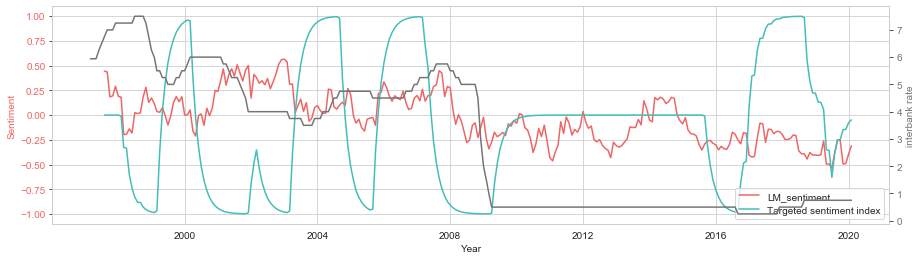

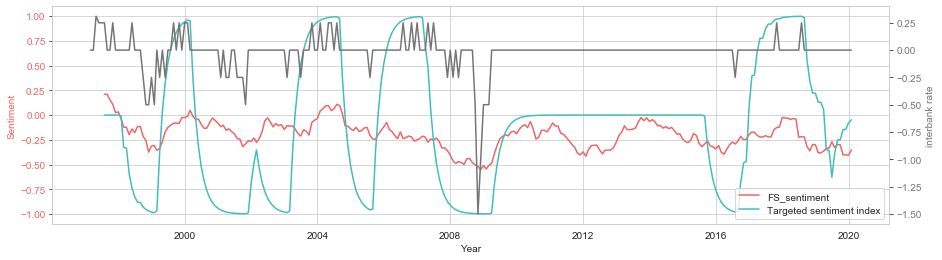

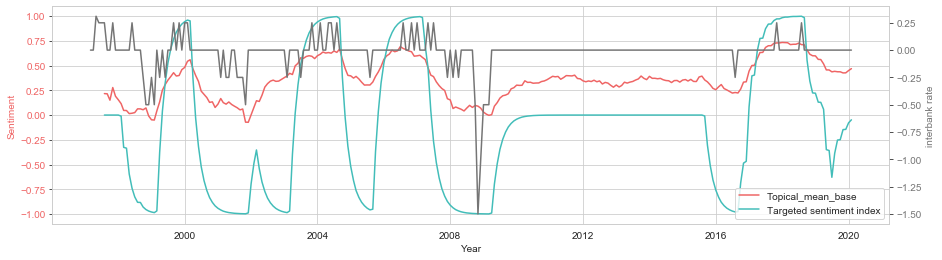

In [201]:
create_comparison_plot(df1,'LM_sentiment',rate = 'Interest_rate')
create_comparison_plot(df1,'FS_sentiment',rate = 'change_of_rate')
create_comparison_plot(df1,'Topical_mean_base',rate = 'change_of_rate')

## Part 3.2 analysis performance accross different time range

calculating all
calculating topic: The immediate policy decision
calculating topic: Money, credit, demand and output
calculating topic: Supply, costs and prices
calculating topic: The international economy
calculating dictionary sentiment


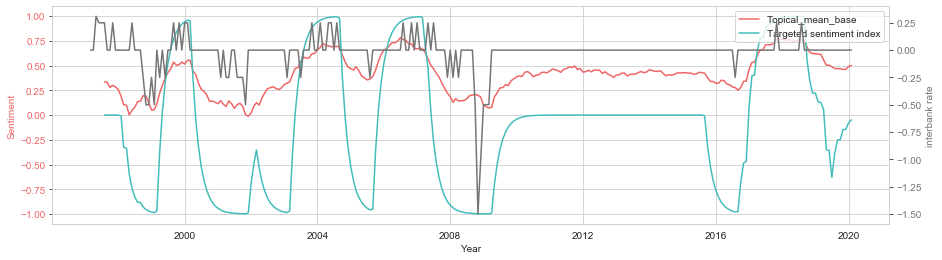

In [13]:
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']
sentiment_97_20 = result_dictionary_sentiment(dictionary_model_97_20,interested_topics)
sentiment_97_20.corr().iloc[[0,1,16,17],:]
create_comparison_plot(sentiment_97_20,'Topical_mean_base',rate = 'change_of_rate')

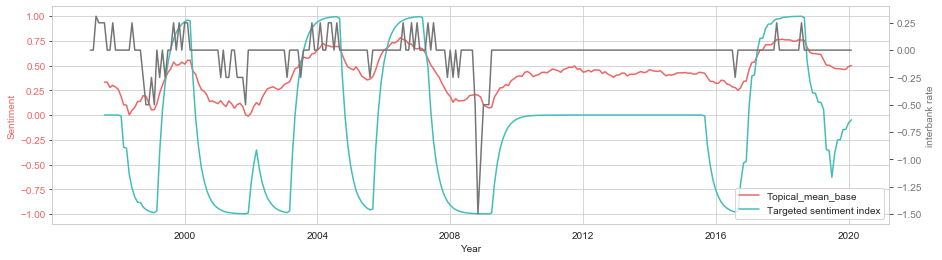

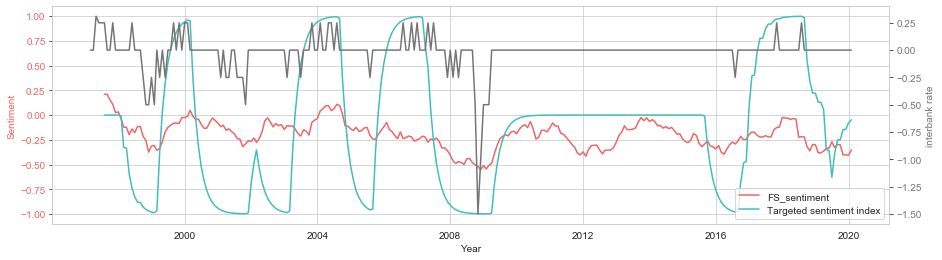

In [52]:
sentiment_97_20.corr().iloc[[0,1,16,17],:]
create_comparison_plot(sentiment_97_20,'Topical_mean_base',rate = 'change_of_rate')
create_comparison_plot(sentiment_97_20,'FS_sentiment',rate = 'change_of_rate')

Positive count:37   Negative count:53   Neutral count:10
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:34   Negative count:58   Neutral count:8
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: The immediate policy decision
calculating topic: Money, cr

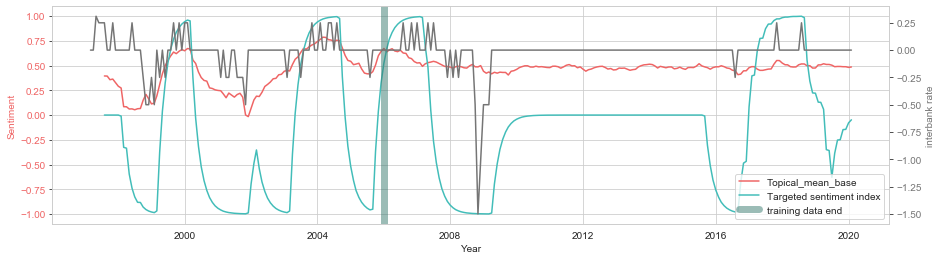

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.468648             0.494101   
label_2         0.638712  1.000000            0.671831             0.369794   
Interest_rate  -0.137836 -0.202106           -0.302007            -0.452590   
change_of_rate  0.242726  0.419701            0.302378             0.096983   

                base_The immediate policy decision_sentiment  \
label                                               0.487121   
label_2                                             0.603643   
Interest_rate                                       0.189778   
change_of_rate                                      0.311232   

                libor_The immediate policy decision_sentiment  \
label                                                0.641031   
label_2                                              0.461913   
Interest_rate                                       -0.136824   
change_of_rate                                       0.172213   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.422647   
label_2                                                0.630734   
Interest_rate                                         -0.050210   
change_of_rate                                         0.259638   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.540192   
label_2                                                 0.486739   
Interest_rate                                          -0.399572   
change_of_rate                                          0.164426   

                base_Supply, costs and prices_sentiment  \
label                                          0.374326   
label_2                                        0.607605   
Interest_rate                                 -0.548379   
change_of_rate                                 0.232958   

                libor_Supply, costs and prices_sentiment  \
label                                           0.514599   
label_2                                         0.364577   
Interest_rate                                  -0.453476   
change_of_rate                                  0.119009   

                base_The international economy_sentiment  \
label                                           0.439645   
label_2                                         0.600509   
Interest_rate                                  -0.316315   
change_of_rate                                  0.254431   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.489548           0.457522   
label_2                                          0.468888           0.645989   
Interest_rate                                   -0.430598          -0.265944   
change_of_rate                                   0.226511           0.267311   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.548437      0.399016      0.066243      -0.137836   
label_2                   0.450723      0.399228     -0.139119      -0.202106   
Interest_rate            -0.456285      0.245016      0.641400       1.000000   
change_of_rate            0.125873      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

In [35]:
end_date, start_date='2005-12-31','1997-08-01'
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

training_data = minutes_timeseries.loc[end_date:start_date]
word_document_frequency_97_05,dictionary_model_97_05 = training_dictionary_sentiment(training_data,para_set=[[10,0.55,0.6],[5,0.55,0.6]])
sentiment_97_05 = result_dictionary_sentiment(dictionary_model_97_05,interested_topics)
create_comparison_plot(sentiment_97_05,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
sentiment_97_05.corr().iloc[[0,1,16,17],:]

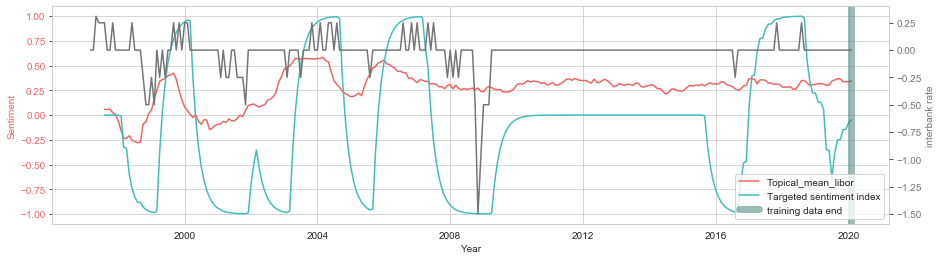

In [203]:
create_comparison_plot(sentiment_97_05,'Topical_mean_libor',rate = 'change_of_rate', end_date='2005-12-31')

Positive count:68   Negative count:79   Neutral count:13
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:48   Negative count:81   Neutral count:31
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: The immediate policy decision
calculating topic: Money, c

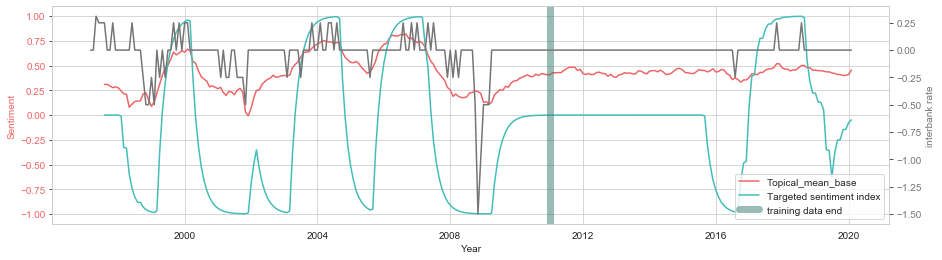

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.556536             0.581103   
label_2         0.638712  1.000000            0.701805             0.540145   
Interest_rate  -0.137836 -0.202106            0.021488            -0.721913   
change_of_rate  0.242726  0.419701            0.422545             0.290496   

                base_The immediate policy decision_sentiment  \
label                                               0.516638   
label_2                                             0.703123   
Interest_rate                                       0.117617   
change_of_rate                                      0.418617   

                libor_The immediate policy decision_sentiment  \
label                                                0.607191   
label_2                                              0.534819   
Interest_rate                                       -0.709220   
change_of_rate                                       0.278963   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.528429   
label_2                                                0.757339   
Interest_rate                                          0.196358   
change_of_rate                                         0.383369   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.670768   
label_2                                                 0.541407   
Interest_rate                                          -0.578072   
change_of_rate                                          0.247104   

                base_Supply, costs and prices_sentiment  \
label                                          0.449994   
label_2                                        0.707895   
Interest_rate                                 -0.108876   
change_of_rate                                 0.429903   

                libor_Supply, costs and prices_sentiment  \
label                                           0.511581   
label_2                                         0.441162   
Interest_rate                                  -0.710432   
change_of_rate                                  0.187715   

                base_The international economy_sentiment  \
label                                           0.537399   
label_2                                         0.743201   
Interest_rate                                  -0.085070   
change_of_rate                                  0.405132   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.687401           0.534025   
label_2                                          0.608466           0.764027   
Interest_rate                                   -0.436398          -0.062262   
change_of_rate                                   0.351426           0.408721   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.596630      0.399016      0.066243      -0.137836   
label_2                   0.526435      0.399228     -0.139119      -0.202106   
Interest_rate            -0.706805      0.245016      0.641400       1.000000   
change_of_rate            0.230655      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

In [36]:
end_date, start_date='2010-12-31','1997-08-01'
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

training_data = minutes_timeseries.loc[end_date:start_date]
word_document_frequency_97_10,dictionary_model_97_10 = training_dictionary_sentiment(training_data,para_set=[[17,0.55,0.6],[7,0.55,0.6]])
sentiment_97_10 = result_dictionary_sentiment(dictionary_model_97_10,interested_topics)
create_comparison_plot(sentiment_97_10,'Topical_mean_base',rate = 'change_of_rate',end_date=end_date)
sentiment_97_10.corr().iloc[[0,1,16,17],:]

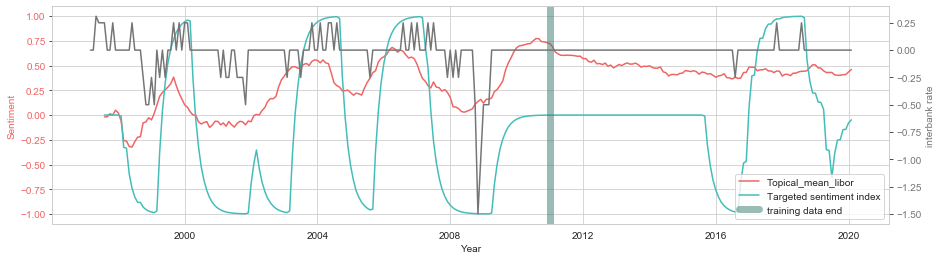

In [204]:
create_comparison_plot(sentiment_97_10,'Topical_mean_libor',rate = 'change_of_rate', end_date='2010-12-31')

Positive count:80   Negative count:103   Neutral count:37
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:48   Negative count:85   Neutral count:87
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: The immediate policy decision
calculating topic: Money, 

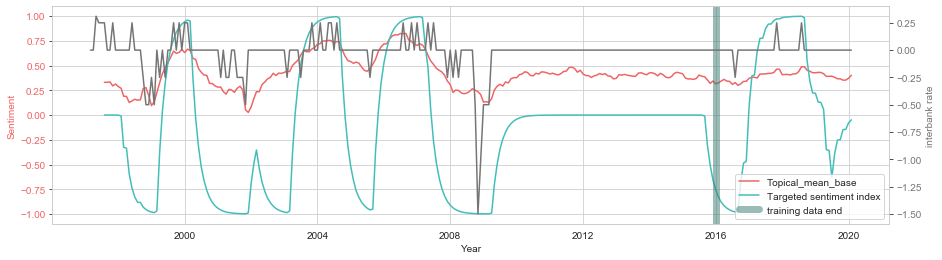

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.638712            0.534324             0.765035   
label_2         0.638712  1.000000            0.640308             0.557790   
Interest_rate  -0.137836 -0.202106            0.126248            -0.449656   
change_of_rate  0.242726  0.419701            0.378936             0.312433   

                base_The immediate policy decision_sentiment  \
label                                               0.544449   
label_2                                             0.654406   
Interest_rate                                       0.263344   
change_of_rate                                      0.382291   

                libor_The immediate policy decision_sentiment  \
label                                                0.780184   
label_2                                              0.593734   
Interest_rate                                       -0.472152   
change_of_rate                                       0.307363   

                base_Money, credit, demand and output_sentiment  \
label                                                  0.511813   
label_2                                                0.696512   
Interest_rate                                          0.328990   
change_of_rate                                         0.353628   

                libor_Money, credit, demand and output_sentiment  \
label                                                   0.737734   
label_2                                                 0.530762   
Interest_rate                                          -0.454859   
change_of_rate                                          0.269110   

                base_Supply, costs and prices_sentiment  \
label                                          0.468840   
label_2                                        0.717627   
Interest_rate                                  0.018895   
change_of_rate                                 0.431583   

                libor_Supply, costs and prices_sentiment  \
label                                           0.642767   
label_2                                         0.391880   
Interest_rate                                  -0.431240   
change_of_rate                                  0.237716   

                base_The international economy_sentiment  \
label                                           0.504517   
label_2                                         0.683071   
Interest_rate                                  -0.019880   
change_of_rate                                  0.417570   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.801740           0.545558   
label_2                                          0.592670           0.735766   
Interest_rate                                   -0.132349           0.059473   
change_of_rate                                   0.349079           0.395792   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.733659      0.399016      0.066243      -0.137836   
label_2                   0.541198      0.399228     -0.139119      -0.202106   
Interest_rate            -0.516300      0.245016      0.641400       1.000000   
change_of_rate            0.265916      0.408340     -0.027290      -0.054722   

                change_of_rate  
label                 0.242726  
label_2               0.419701  
Interest_rate        -0.054722  
change_of_rate        1.000000

In [48]:
end_date, start_date='2015-12-31','1997-08-01'
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']

training_data = minutes_timeseries.loc[end_date:start_date]
word_document_frequency_97_15,dictionary_model_97_15 = training_dictionary_sentiment(training_data,para_set=[[25,0.55,0.6],[15,0.55,0.6]])
sentiment_97_15 = result_dictionary_sentiment(dictionary_model_97_15,interested_topics)
create_comparison_plot(sentiment_97_15,'Topical_mean_base',rate = 'change_of_rate',end_date=end_date)
sentiment_97_15.corr().iloc[[0,1,16,17],:]

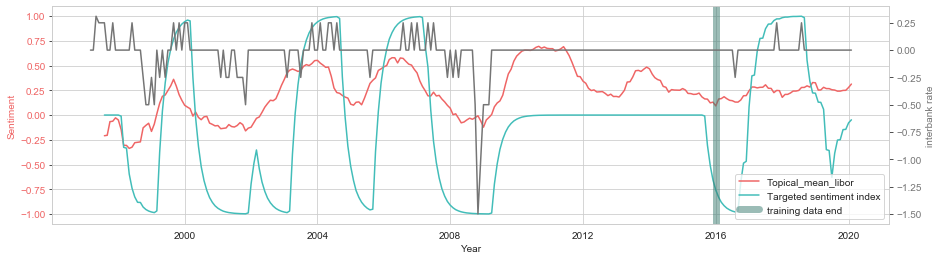

In [205]:
create_comparison_plot(sentiment_97_15,'Topical_mean_libor',rate = 'change_of_rate', end_date='2015-12-31')

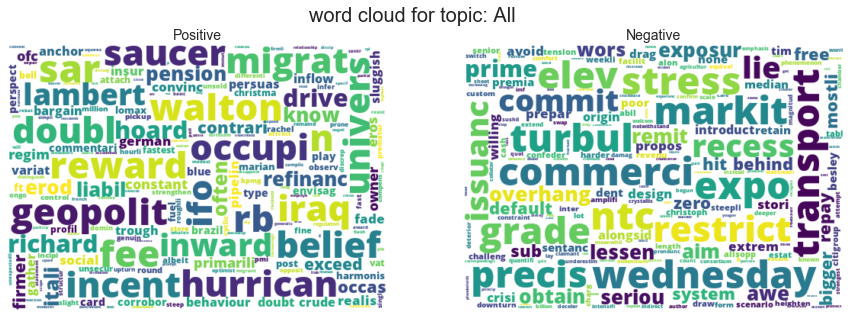

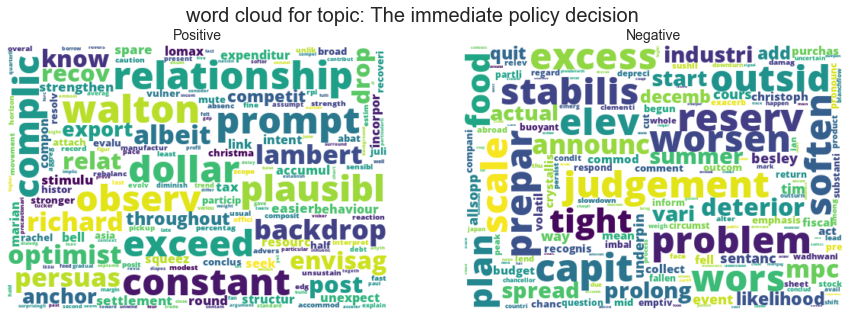

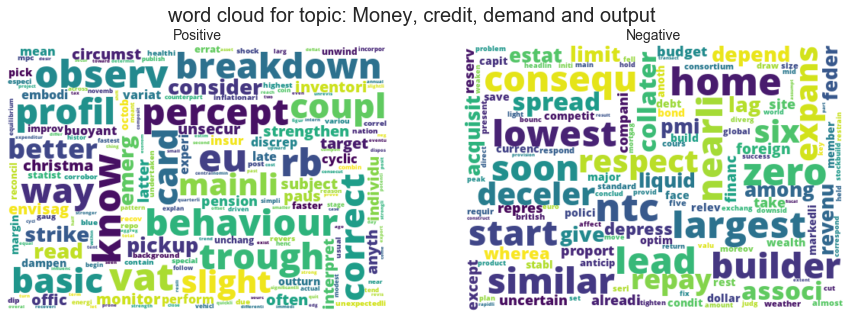

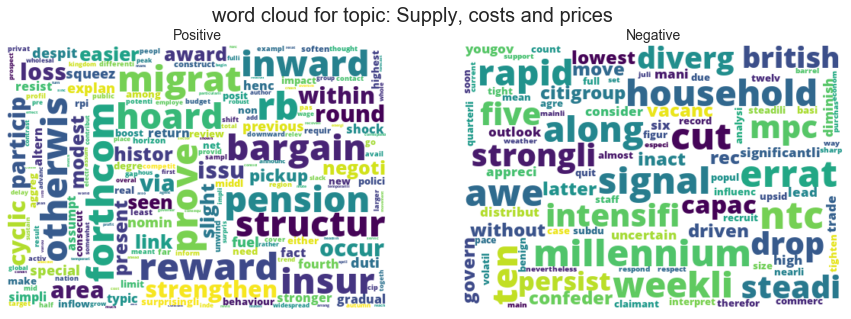

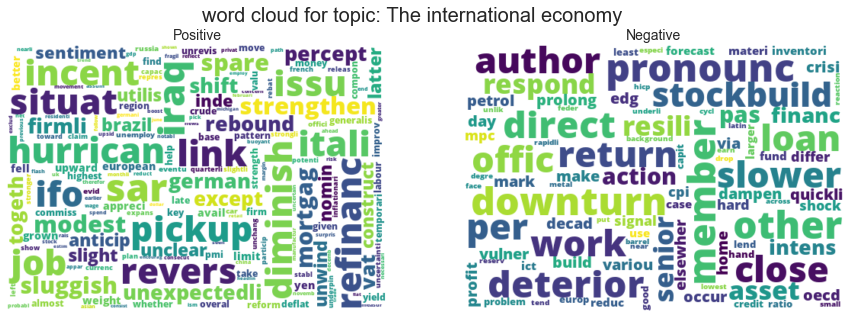

In [58]:
para = [10,0.55,0.6]
create_dictionary_visualisation(word_document_frequency_97_15,para)

## Part 3.3 Including speech as part of training data

In [176]:
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora

def load_up_from_cleaned_speech():
    MPC_speech = pd.read_excel('./scripter/cleaned_dataset/MPC_speech.xlsx')
    file_list = os.listdir("./scripter/cleaned_dataset/Speech_MPC")
    for n,file in enumerate(file_list):
        text_file = open("./scripter/cleaned_dataset/Speech_MPC/{}".format(file), "r").read()
        MPC_speech.loc[MPC_speech['title']==file[:-4],'document_string'] = text_file
    return MPC_speech

def sentiment_calculator_speech(dictionary,doc_list):
    document = ''
    for para in doc_list:      
        document += para+' '
    tokens = tokenizer.tokenize(document.lower())
    stemmed_tokens = [lemma.lemmatize(p_stemmer.stem(i)) for i in tokens if (i not in en_stop) and (i not in exclude)]
    Positive_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Positive',:].copy()
    Positive_df.loc[:,'Count'] = Positive_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    Negative_df = dictionary.loc[dictionary.loc[:,'sentiment']=='Negative',:].copy()
    Negative_df.loc[:,'Count'] = Negative_df.loc[:,'Entry'].apply(lambda x: stemmed_tokens.count(x))
    try:
        return (sum(Positive_df.Count)-sum(Negative_df.Count))/(sum(Positive_df.Count)+sum(Negative_df.Count))
    except:
        return np.nan
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def filter_speech_language(string,topics,thre=0.65):
    result = {i:[] for i in topics}
    string1 = str(string).split(' ###newline### ')
    doc_list = []
    for string in string1:
        doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]
    doc_list_cleaned = preprocess_data(doc_list)
    _, corpus =  prepare_corpus(doc_list_cleaned)
    corpus_tfidf = TfidfModel(corpus)[corpus]
    for n,sentence in enumerate(corpus_tfidf):
        a = model_2.get_document_topics(sentence)
        a.sort(key=lambda x:-x[1])
        topic = topics[a[0][0]]
        if a[0][1]>= thre:
            result[topic].append(doc_list[n])
    result = [[topic]+result[topic] for topic in topics]        
    return result

model_2 =  LdaMulticore.load('.\Dictionary_based_method\lda_minutes.model')

In [168]:
MPC_speech = load_up_from_cleaned_speech()
MPC_speech.loc[:,'N_topics'] = MPC_speech.loc[:,'document_string'].apply(lambda x: str(x).split(' ###newline### '))
doc_list = [i for i in MPC_speech.loc[0,'N_topics'][2].split('.') if len(i.split())>=10 and 'thank' not in i and 'grate' not in i and 'gratitude' not in i]
doc_list+=['That is not where you would find the smoking gun']


doc_list_cleaned = preprocess_data(doc_list)
_, corpus =  prepare_corpus(doc_list_cleaned)
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
for n in range(75,81):
    print(doc_list[n])
    print(model_2.get_document_topics(corpus_tfidf[n]))


 Some firms may temporarily switch to very simple and resilient supply chains, even if more costly, and gradually revert to more complex but cheaper supply chains over time if that proves possible
[(0, 0.22630931), (1, 0.1269121), (2, 0.5437467), (3, 0.03437754), (4, 0.034346547), (5, 0.034307834)]
 However, I think it is likely that, provided inflation expectations remain contained, the background of ample labour market slack and subdued activity levels will keep a lid on labour costs and margins, so that inflation will remain fairly limited as long as activity is well below its pre-Covid trend
[(0, 0.028881617), (1, 0.061386157), (2, 0.7474634), (3, 0.028696753), (4, 0.028773008), (5, 0.104799)]
 After all, even before the Covid outbreak, domestic inflation pressures had been modest in recent years, not just in the UK but in other advanced economies
[(0, 0.7539732), (1, 0.03913111), (2, 0.08899647), (3, 0.040064763), (4, 0.03900833), (5, 0.038826123)]
 The resources that allowed the 

In [175]:
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']
interested_topics =['The immediate policy decision','Money, credit, demand and output','Supply, costs and prices','The international economy']
result = {i:[] for i in topics[:-1]}

string1 = MPC_speech.loc[100,'document_string']
string1 = str(string1).split(' ###newline### ')

doc_list = []
for string in string1:
    doc_list += [i for i in string.split('. ') if len(i.split())>=5 and 'thank' not in i.lower() and 'grate' not in i.lower()  and 'gratitude' not in i.lower() ]

doc_list_cleaned = preprocess_data(doc_list)
_, corpus =  prepare_corpus(doc_list_cleaned)
corpus_tfidf = TfidfModel(corpus)[corpus]
k=0
for n,sentence in enumerate(corpus_tfidf):
    a = model_2.get_document_topics(sentence)
    a.sort(key=lambda x:-x[1])
    topic = topics[a[0][0]]
    if a[0][1]>= 0.65:
        result[topic].append(doc_list[n])
        k+=1
result = [[topic]+result[topic] for topic in topics]        
print(k/len(doc_list))
result

0.3853211009174312


[['Financial markets',
  'Once short-term shocks to the economy dissipated, this was the level that interest rates were expected to return to',
  'the structure of the economy and the financial system',
  'I will provide some theoretical arguments on what determines the equilibrium real rate, and I will provide some data and some model calibrations that suggest the theory matches the data rather well',
  'The first step is to understand that the equilibrium real rate depends on how risky the economy is, and that this riskiness changes over time',
  'The second step, somewhat more speculative, is to try to understand why the riskiness of the economy may change',
  'It turns out that the asymmetry of booms and busts, as well as the fatness of the tails, have changed significantly over the past few centuries: in the past century, business cycles have become more asymmetric and more fat-tailed, relative to the gold standard era of the th and th century',
  'And these changes can explain wh

In [177]:

MPC_speech = load_up_from_cleaned_speech()
# now apply the above method and covnert the language of speech
MPC_speech.loc[:,'N_topics'] = MPC_speech.loc[:,'document_string'].apply(lambda x: filter_speech_language(x,topics[:-1],thre=0.65))
MPC_speech.head()

Unnamed: 0                                              title  \
0           0  Covid-19 and monetary policy - speech by Micha...   
1           1  Monetary policy and the Bank of England’s bala...   
2           2  Monetary policy during pandemics inflation bef...   
3           3  The grand unifying theory (and practice) of ma...   
4           4  Inflation and beliefs about inflation - speech...   

                                                link           date  \
0  https://www.bankofengland.co.uk/speech/2020/sp...    28 May 2020   
1  https://www.bankofengland.co.uk/speech/2020/ge...  23 April 2020   
2  https://www.bankofengland.co.uk/speech/2020/si...  16 April 2020   
3  https://www.bankofengland.co.uk/speech/2020/ma...  05 March 2020   
4  https://www.bankofengland.co.uk/speech/2020/be...  04 March 2020   

                             tag  \
0  // Speech // Michael Saunders   
1   // Speech // Gertjan Vlieghe   
2  // Speech // Silvana Tenreyro   
3       // Speech // Mark Carney   
4     // Speech // Ben Broadbent   

                                     document_string  \
0   The views expressed here are not necessarily ...   
1   I would like to thank Rodrigo Guimaraes, Lenn...   
2   The views are not necessarily those of the Ba...   
3   I would like to thank Daisy McGregor, Nicola ...   
4   I ve received helpful comments from colleague...   

                                            N_topics  
0  [[Financial markets, Moreover, with limited mo...  
1  [[Financial markets, It is far more complex th...  
2  [[Financial markets, Second, the policy respon...  
3  [[Financial markets, Macroprudential policy is...  
4  [[Financial markets, Precisely for that reason...

In [271]:
minutes_timeseries

speech_timeseries = MPC_speech.set_index('date')
speech_timeseries.index = pd.DatetimeIndex(speech_timeseries.index)+pd.offsets.MonthBegin(0)
speech_timeseries = speech_timeseries.loc[:,['title','N_topics']]

MPC_minutes = pd.read_hdf('data.h5', 'minutes')
minutes_timeseries2 = MPC_minutes.loc[:,['date','title','N_topics']]
minutes_timeseries2 = minutes_timeseries2.set_index('date')
minutes_timeseries2.index = pd.DatetimeIndex(minutes_timeseries2.index)+pd.offsets.MonthBegin(0)
merged_timeseries = pd.concat([speech_timeseries,minutes_timeseries2]).sort_index(ascending=False)

label_df = pd.DataFrame(data={'label':rate_change},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries.index]
merged_timeseries.loc[:,'label'] = label_list

label_df = pd.DataFrame(data={'label':rate_change_2},index = pd.DatetimeIndex(date_range))
label_list = [label_df.loc[i,'label'] for i in merged_timeseries.index]
merged_timeseries.loc[:,'label_2'] = label_list
merged_timeseries

title  \
date                                                            
2020-06-01  Covid-19 and monetary policy - speech by Micha...   
2020-06-01         Bank Rate maintained at 01% - May 2020_1st   
2020-05-01  Monetary policy during pandemics inflation bef...   
2020-05-01  Monetary policy and the Bank of England’s bala...   
2020-04-01  Minutes of the special Monetary Policy Committ...   
...                                                       ...   
1997-09-01  Minutes of the MPC Meeting held on 9 and 10 Ju...   
1997-08-01  Minutes of the MPC Meeting held on 5 and 6 Jun...   
1997-07-01      Lord Mayors Banquet - speech by Edward George   
1997-07-01  The Sixteenth Mais Lecture - speech by Edward ...   
1997-03-01  Speech by Edward George for the 3rd Euromoney ...   

                                                     N_topics  label  label_2  
date                                                                           
2020-06-01  [[Financial markets, Moreover, with limited mo...      0        0  
2020-06-01  [[Growth and inflation projections, Authoritie...      0        0  
2020-05-01  [[Financial markets, Second, the policy respon...      0        0  
2020-05-01  [[Financial markets, It is far more complex th...      0        0  
2020-04-01  [[Financial markets, Since the January MPC mee...      0        0  
...                                                       ...    ...      ...  
1997-09-01  [[Financial markets, The estimated change in n...      0        1  
1997-08-01  [[Financial markets, Short-term interest rates...      0        1  
1997-07-01  [[Financial markets, It operates with long and...      0        1  
1997-07-01  [[Financial markets, Sweeping generalisations ...      0        1  
1997-03-01  [[Financial markets, One concern at the time w...      0        1  

[1044 rows x 4 columns]

Positive count:344   Negative count:470   Neutral count:216
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:244   Negative count:351   Neutral count:435
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: Financial markets
calculating topic: The immediate 

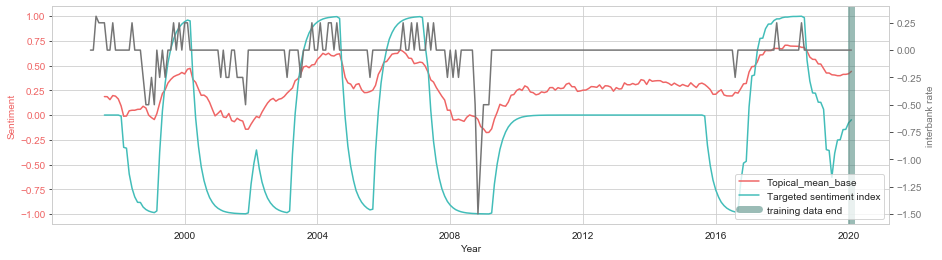

label   label_2  base_all_sentiment  libor_all_sentiment  \
label         1.000000  0.638712            0.519638             0.830537   
label_2       0.638712  1.000000            0.764803             0.642966   
FS_sentiment  0.399016  0.399228            0.251755             0.313909   
LM_sentiment  0.066243 -0.139119           -0.355794            -0.084712   

              base_Financial markets_sentiment  \
label                                 0.530263   
label_2                               0.786227   
FS_sentiment                          0.317380   
LM_sentiment                         -0.192286   

              libor_Financial markets_sentiment  \
label                                  0.757485   
label_2                                0.649131   
FS_sentiment                           0.426461   
LM_sentiment                           0.081854   

              base_The immediate policy decision_sentiment  \
label                                             0.494843   
label_2                                           0.787907   
FS_sentiment                                      0.289349   
LM_sentiment                                     -0.319256   

              libor_The immediate policy decision_sentiment  \
label                                              0.784391   
label_2                                            0.620918   
FS_sentiment                                       0.147776   
LM_sentiment                                      -0.177808   

              base_Growth and inflation projections_sentiment  \
label                                                0.462699   
label_2                                              0.690971   
FS_sentiment                                         0.473139   
LM_sentiment                                        -0.072824   

              libor_Growth and inflation projections_sentiment  ...  \
label                                                 0.714610  ...   
label_2                                               0.645698  ...   
FS_sentiment                                          0.439784  ...   
LM_sentiment                                          0.140896  ...   

              base_Supply, costs and prices_sentiment  \
label                                        0.454169   
label_2                                      0.821985   
FS_sentiment                                 0.322403   
LM_sentiment                                -0.210025   

              libor_Supply, costs and prices_sentiment  \
label                                         0.703400   
label_2                                       0.507094   
FS_sentiment                                  0.211210   
LM_sentiment                                 -0.090509   

              base_The international economy_sentiment  \
label                                         0.535309   
label_2                                       0.753029   
FS_sentiment                                  0.236111   
LM_sentiment                                 -0.403769   

              libor_The international economy_sentiment  Topical_mean_base  \
label                                          0.751076           0.554551   
label_2                                        0.540236           0.867652   
FS_sentiment                                   0.384534           0.344702   
LM_sentiment                                   0.127423          -0.233952   

              Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                   0.854846      0.399016      0.066243      -0.137836   
label_2                 0.662550      0.399228     -0.139119      -0.202106   
FS_sentiment            0.317250      1.000000      0.361575       0.245016   
LM_sentiment           -0.020320      0.361575      1.000000       0.641400   

              change_of_rate  
label               0.242726  
label_2             0.419701  
FS_sentiment        0.408340  
LM_sentiment       -0.027290  

[4 r

In [197]:
end_date, start_date='2020-02-01','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']

training_data = merged_timeseries.loc[end_date:start_date,:]
word_document_frequency_97_20_merged,dictionary_model_97_20_merged = training_dictionary_sentiment(training_data,para_set=[[40,0.55,0.6],[20,0.55,0.6]])
sentiment_97_20_merged = result_dictionary_sentiment(dictionary_model_97_20_merged,interested_topics)
create_comparison_plot(sentiment_97_20_merged,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
sentiment_97_20_merged.corr().iloc[[0,1,18,19],:]

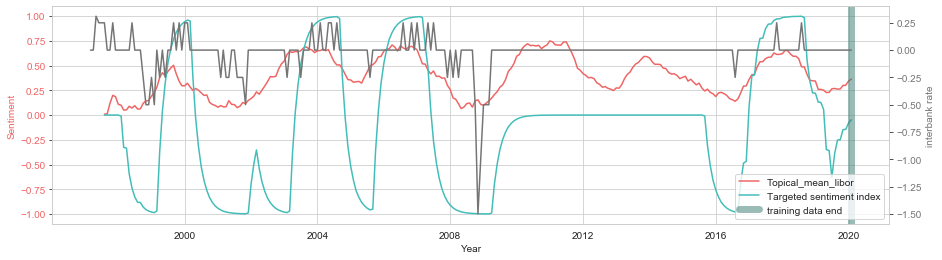

In [202]:
create_comparison_plot(sentiment_97_20_merged,'Topical_mean_libor',rate = 'change_of_rate', end_date=end_date)

Positive count:115   Negative count:180   Neutral count:18
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:106   Negative count:190   Neutral count:17
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: Financial markets
calculating topic: The immediate po

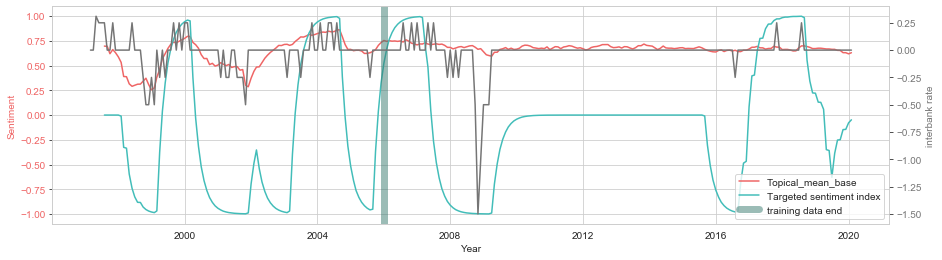

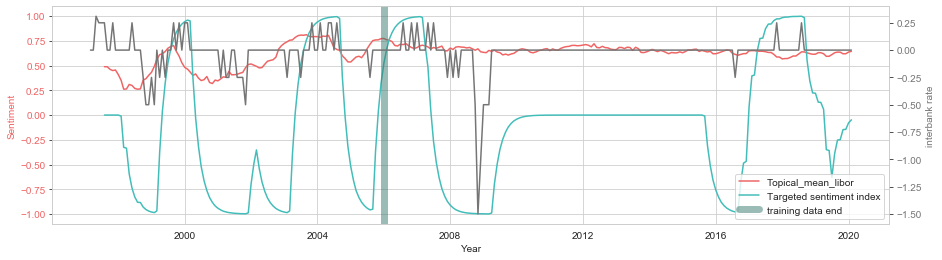

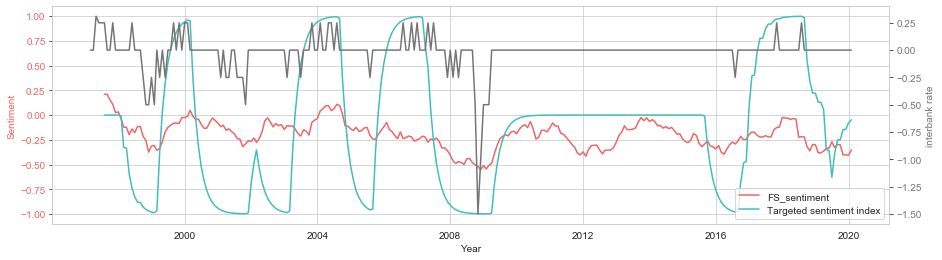

label   label_2  base_all_sentiment  libor_all_sentiment  \
label         1.000000  0.638712            0.396819             0.340605   
label_2       0.638712  1.000000            0.431958             0.257034   
FS_sentiment  0.399016  0.399228            0.028349            -0.186306   
LM_sentiment  0.066243 -0.139119           -0.029942            -0.095618   

              base_Financial markets_sentiment  \
label                                 0.354338   
label_2                               0.580851   
FS_sentiment                          0.018831   
LM_sentiment                         -0.402760   

              libor_Financial markets_sentiment  \
label                                  0.352224   
label_2                                0.404707   
FS_sentiment                          -0.117773   
LM_sentiment                          -0.205286   

              base_The immediate policy decision_sentiment  \
label                                             0.461364   
label_2                                           0.594285   
FS_sentiment                                      0.292640   
LM_sentiment                                     -0.084058   

              libor_The immediate policy decision_sentiment  \
label                                              0.523165   
label_2                                            0.301322   
FS_sentiment                                      -0.104551   
LM_sentiment                                       0.006215   

              base_Growth and inflation projections_sentiment  \
label                                               -0.038505   
label_2                                              0.157118   
FS_sentiment                                         0.150498   
LM_sentiment                                         0.268078   

              libor_Growth and inflation projections_sentiment  ...  \
label                                                 0.098966  ...   
label_2                                               0.112378  ...   
FS_sentiment                                         -0.172197  ...   
LM_sentiment                                          0.248358  ...   

              base_Supply, costs and prices_sentiment  \
label                                        0.355522   
label_2                                      0.581207   
FS_sentiment                                 0.149988   
LM_sentiment                                -0.363162   

              libor_Supply, costs and prices_sentiment  \
label                                         0.425943   
label_2                                       0.327529   
FS_sentiment                                 -0.194805   
LM_sentiment                                 -0.260267   

              base_The international economy_sentiment  \
label                                         0.468642   
label_2                                       0.559183   
FS_sentiment                                  0.011805   
LM_sentiment                                 -0.474385   

              libor_The international economy_sentiment  Topical_mean_base  \
label                                          0.455941           0.399319   
label_2                                        0.419131           0.586495   
FS_sentiment                                   0.054998           0.184344   
LM_sentiment                                  -0.351748          -0.144774   

              Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                   0.472719      0.399016      0.066243      -0.137836   
label_2                 0.383062      0.399228     -0.139119      -0.202106   
FS_sentiment           -0.198037      1.000000      0.361575       0.245016   
LM_sentiment           -0.174908      0.361575      1.000000       0.641400   

              change_of_rate  
label               0.242726  
label_2             0.419701  
FS_sentiment        0.408340  
LM_sentiment       -0.027290  

[4 r

In [209]:
end_date, start_date='2005-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']

training_data = merged_timeseries.loc[end_date:start_date,:]
word_document_frequency_97_05_merged,dictionary_model_97_05_merged = training_dictionary_sentiment(training_data,para_set=[[30,0.55,0.6],[15,0.55,0.6]])
sentiment_97_05_merged = result_dictionary_sentiment(dictionary_model_97_05_merged,interested_topics)
create_comparison_plot(sentiment_97_05_merged,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_05_merged,'Topical_mean_libor',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_05_merged,'FS_sentiment',rate = 'change_of_rate')
sentiment_97_05_merged.corr().iloc[[0,1,18,19],:]

Positive count:227   Negative count:284   Neutral count:34
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:154   Negative count:279   Neutral count:112
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: Financial markets
calculating topic: The immediate p

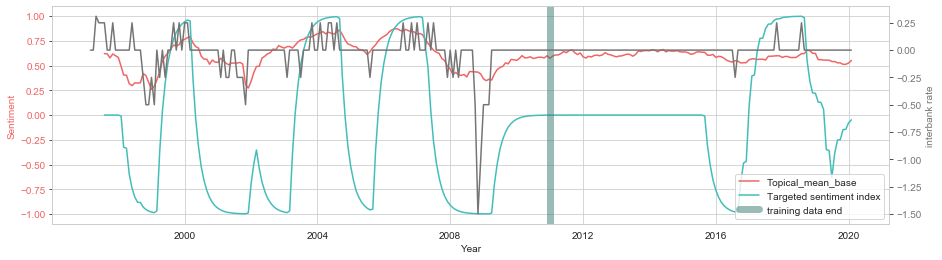

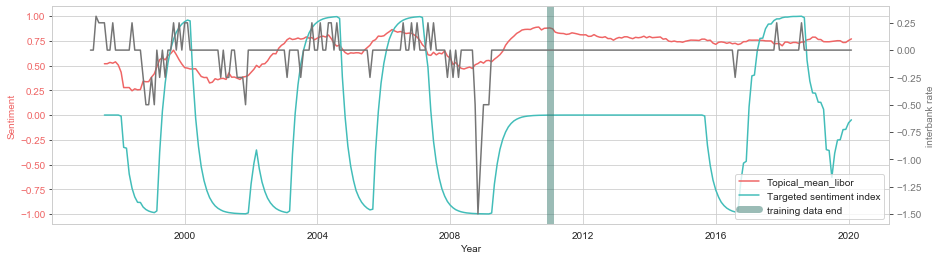

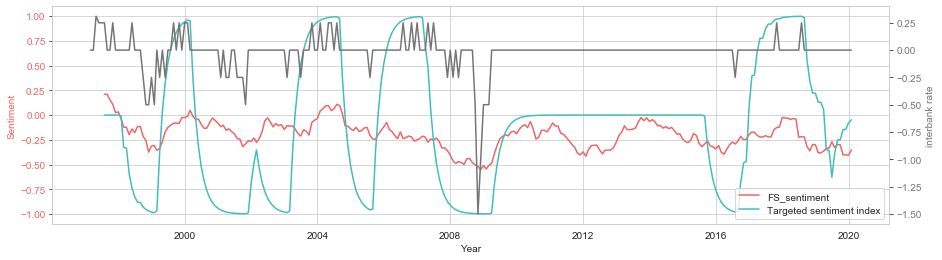

label   label_2  base_all_sentiment  libor_all_sentiment  \
label         1.000000  0.638712            0.530029             0.547709   
label_2       0.638712  1.000000            0.711811             0.463622   
FS_sentiment  0.399016  0.399228            0.481409             0.096194   
LM_sentiment  0.066243 -0.139119           -0.002036            -0.365275   

              base_Financial markets_sentiment  \
label                                 0.538602   
label_2                               0.750213   
FS_sentiment                          0.286877   
LM_sentiment                         -0.169032   

              libor_Financial markets_sentiment  \
label                                  0.472614   
label_2                                0.555432   
FS_sentiment                           0.058426   
LM_sentiment                          -0.413327   

              base_The immediate policy decision_sentiment  \
label                                             0.482107   
label_2                                           0.613784   
FS_sentiment                                      0.584951   
LM_sentiment                                      0.278539   

              libor_The immediate policy decision_sentiment  \
label                                              0.588816   
label_2                                            0.519095   
FS_sentiment                                       0.049114   
LM_sentiment                                      -0.371799   

              base_Growth and inflation projections_sentiment  \
label                                                0.286468   
label_2                                              0.517338   
FS_sentiment                                         0.567884   
LM_sentiment                                         0.252493   

              libor_Growth and inflation projections_sentiment  ...  \
label                                                 0.505638  ...   
label_2                                               0.516815  ...   
FS_sentiment                                          0.097291  ...   
LM_sentiment                                         -0.191740  ...   

              base_Supply, costs and prices_sentiment  \
label                                        0.397231   
label_2                                      0.633930   
FS_sentiment                                 0.494538   
LM_sentiment                                 0.200781   

              libor_Supply, costs and prices_sentiment  \
label                                         0.368309   
label_2                                       0.295482   
FS_sentiment                                 -0.200908   
LM_sentiment                                 -0.356220   

              base_The international economy_sentiment  \
label                                         0.495129   
label_2                                       0.713857   
FS_sentiment                                  0.319412   
LM_sentiment                                 -0.103577   

              libor_The international economy_sentiment  Topical_mean_base  \
label                                          0.645598           0.483052   
label_2                                        0.617463           0.668391   
FS_sentiment                                   0.338312           0.478137   
LM_sentiment                                  -0.253191           0.188150   

              Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                   0.555970      0.399016      0.066243      -0.137836   
label_2                 0.520769      0.399228     -0.139119      -0.202106   
FS_sentiment           -0.000066      1.000000      0.361575       0.245016   
LM_sentiment           -0.367777      0.361575      1.000000       0.641400   

              change_of_rate  
label               0.242726  
label_2             0.419701  
FS_sentiment        0.408340  
LM_sentiment       -0.027290  

[4 r

In [210]:
end_date, start_date='2010-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']

training_data = merged_timeseries.loc[end_date:start_date,:]
word_document_frequency_97_10_merged,dictionary_model_97_10_merged = training_dictionary_sentiment(training_data,para_set=[[35,0.55,0.6],[18,0.55,0.6]])
sentiment_97_10_merged = result_dictionary_sentiment(dictionary_model_97_10_merged,interested_topics)
create_comparison_plot(sentiment_97_10_merged,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_10_merged,'Topical_mean_libor',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_10_merged,'FS_sentiment',rate = 'change_of_rate')
sentiment_97_10_merged.corr().iloc[[0,1,18,19],:]

Positive count:287   Negative count:396   Neutral count:145
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:154   Negative count:302   Neutral count:372
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: Financial markets
calculating topic: The immediate 

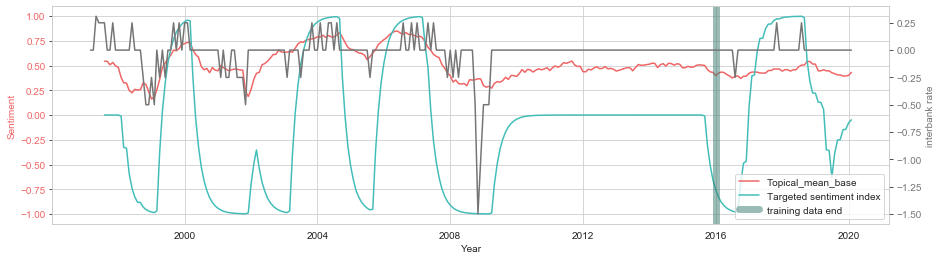

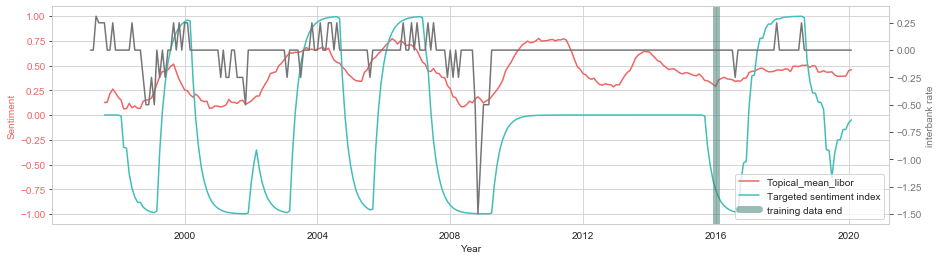

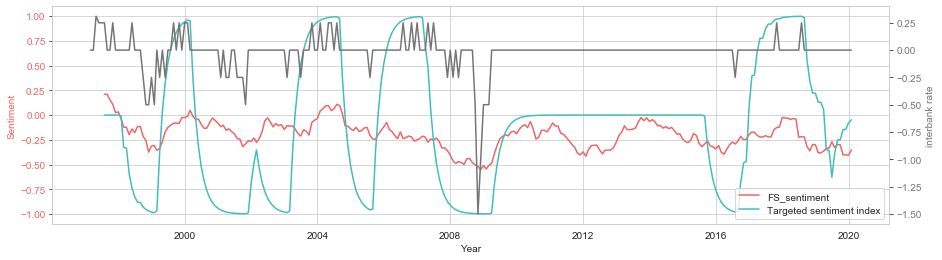

label   label_2  base_all_sentiment  libor_all_sentiment  \
label         1.000000  0.638712            0.438242             0.804243   
label_2       0.638712  1.000000            0.546547             0.592696   
FS_sentiment  0.399016  0.399228            0.539873             0.386992   
LM_sentiment  0.066243 -0.139119            0.349771            -0.054836   

              base_Financial markets_sentiment  \
label                                 0.511871   
label_2                               0.735799   
FS_sentiment                          0.305976   
LM_sentiment                         -0.075142   

              libor_Financial markets_sentiment  \
label                                  0.701685   
label_2                                0.614854   
FS_sentiment                           0.337321   
LM_sentiment                          -0.096173   

              base_The immediate policy decision_sentiment  \
label                                             0.369148   
label_2                                           0.430884   
FS_sentiment                                      0.528641   
LM_sentiment                                      0.484845   

              libor_The immediate policy decision_sentiment  \
label                                              0.766516   
label_2                                            0.595574   
FS_sentiment                                       0.208266   
LM_sentiment                                      -0.186149   

              base_Growth and inflation projections_sentiment  \
label                                                0.163052   
label_2                                              0.384858   
FS_sentiment                                         0.499824   
LM_sentiment                                         0.430703   

              libor_Growth and inflation projections_sentiment  ...  \
label                                                 0.678753  ...   
label_2                                               0.479992  ...   
FS_sentiment                                          0.277089  ...   
LM_sentiment                                          0.144612  ...   

              base_Supply, costs and prices_sentiment  \
label                                        0.448175   
label_2                                      0.684861   
FS_sentiment                                 0.407037   
LM_sentiment                                 0.151902   

              libor_Supply, costs and prices_sentiment  \
label                                         0.682712   
label_2                                       0.420028   
FS_sentiment                                  0.155638   
LM_sentiment                                 -0.073520   

              base_The international economy_sentiment  \
label                                         0.522212   
label_2                                       0.691409   
FS_sentiment                                  0.293268   
LM_sentiment                                 -0.008093   

              libor_The international economy_sentiment  Topical_mean_base  \
label                                          0.766255           0.443186   
label_2                                        0.577956           0.596236   
FS_sentiment                                   0.263315           0.471533   
LM_sentiment                                  -0.126274           0.332402   

              Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                   0.798518      0.399016      0.066243      -0.137836   
label_2                 0.584034      0.399228     -0.139119      -0.202106   
FS_sentiment            0.243640      1.000000      0.361575       0.245016   
LM_sentiment           -0.093186      0.361575      1.000000       0.641400   

              change_of_rate  
label               0.242726  
label_2             0.419701  
FS_sentiment        0.408340  
LM_sentiment       -0.027290  

[4 r

In [212]:
end_date, start_date='2015-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']

training_data = merged_timeseries.loc[end_date:start_date,:]
word_document_frequency_97_15_merged,dictionary_model_97_15_merged = training_dictionary_sentiment(training_data,para_set=[[20,0.55,0.6],[10,0.55,0.6]])
sentiment_97_15_merged = result_dictionary_sentiment(dictionary_model_97_15_merged,interested_topics)
create_comparison_plot(sentiment_97_15_merged,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_15_merged,'Topical_mean_libor',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_15_merged,'FS_sentiment',rate = 'change_of_rate')
sentiment_97_15_merged.corr().iloc[[0,1,18,19],:]

Positive count:287   Negative count:396   Neutral count:145
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
Positive count:154   Negative count:244   Neutral count:430
calculate word frequency
create dictionary for topic: Financial markets
create dictionary for topic: The immediate policy decision
create dictionary for topic: Growth and inflation projections
create dictionary for topic: Money, credit, demand and output
create dictionary for topic: Supply, costs and prices
create dictionary for topic: The international economy
create dictionary for topic: All
calculating all
calculating topic: Financial markets
calculating topic: The immediate 

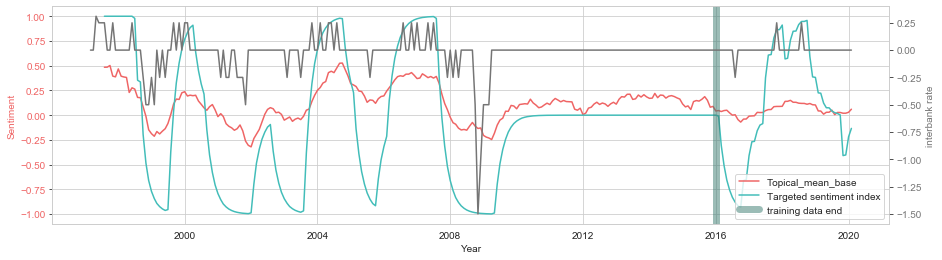

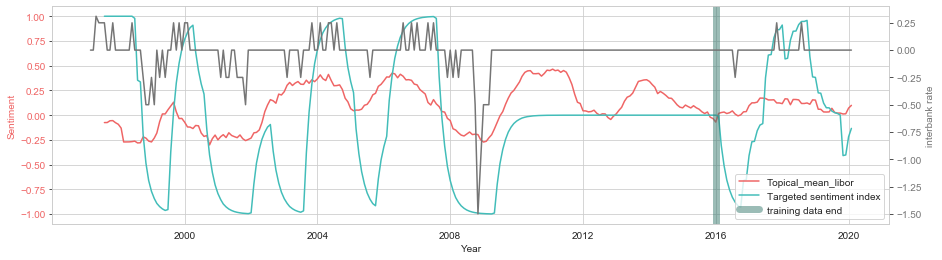

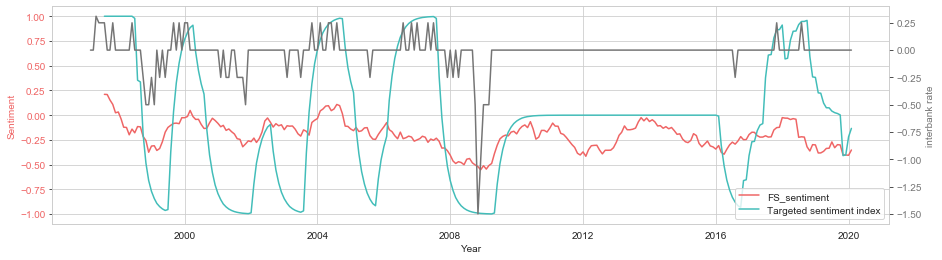

In [272]:
end_date, start_date='2015-12-31','1997-08-01'
interested_topics = [
    'Financial markets',
    'The immediate policy decision',
    'Growth and inflation projections',
    'Money, credit, demand and output',
    'Supply, costs and prices',
    'The international economy',
]
topics =['Financial markets','The immediate policy decision','Growth and inflation projections',
         'Money, credit, demand and output','Supply, costs and prices','The international economy','All']

training_data = merged_timeseries.loc[end_date:start_date,:]
word_document_frequency_97_15_merged,dictionary_model_97_15_merged = training_dictionary_sentiment(training_data,para_set=[[50,0.55,0.55],[30,0.55,0.55]])
sentiment_97_15_merged = result_dictionary_sentiment(dictionary_model_97_15_merged,interested_topics)
create_comparison_plot(sentiment_97_15_merged,'Topical_mean_base',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_15_merged,'Topical_mean_libor',rate = 'change_of_rate', end_date=end_date)
create_comparison_plot(sentiment_97_15_merged,'FS_sentiment',rate = 'change_of_rate')


In [273]:
sentiment_97_15_merged.corr().iloc[[0,1,20,21],:]

label   label_2  base_all_sentiment  libor_all_sentiment  \
label           1.000000  0.280419            0.424784             0.763648   
label_2         0.280419  1.000000            0.798444             0.337964   
Interest_rate  -0.137836  0.053522            0.228104            -0.445964   
change_of_rate  0.242726  0.473355            0.473541             0.386354   

                base_Financial markets_sentiment  \
label                                   0.397091   
label_2                                 0.755363   
Interest_rate                          -0.051136   
change_of_rate                          0.429272   

                libor_Financial markets_sentiment  \
label                                    0.660547   
label_2                                  0.497651   
Interest_rate                           -0.114053   
change_of_rate                           0.353466   

                base_The immediate policy decision_sentiment  \
label                                               0.231634   
label_2                                             0.786976   
Interest_rate                                       0.184519   
change_of_rate                                      0.439690   

                libor_The immediate policy decision_sentiment  \
label                                                0.721793   
label_2                                              0.297748   
Interest_rate                                       -0.502950   
change_of_rate                                       0.334578   

                base_Growth and inflation projections_sentiment  \
label                                                  0.218585   
label_2                                                0.587980   
Interest_rate                                          0.182303   
change_of_rate                                         0.332397   

                libor_Growth and inflation projections_sentiment  ...  \
label                                                   0.544466  ...   
label_2                                                 0.410677  ...   
Interest_rate                                          -0.116169  ...   
change_of_rate                                          0.277349  ...   

                base_Supply, costs and prices_sentiment  \
label                                          0.225704   
label_2                                        0.761159   
Interest_rate                                  0.097989   
change_of_rate                                 0.422466   

                libor_Supply, costs and prices_sentiment  \
label                                           0.638672   
label_2                                         0.056881   
Interest_rate                                  -0.500947   
change_of_rate                                  0.233150   

                base_The international economy_sentiment  \
label                                           0.378279   
label_2                                         0.759606   
Interest_rate                                  -0.034933   
change_of_rate                                  0.404429   

                libor_The international economy_sentiment  Topical_mean_base  \
label                                            0.765116           0.308277   
label_2                                          0.502767           0.816622   
Interest_rate                                   -0.122321           0.192167   
change_of_rate                                   0.335803           0.450784   

                Topical_mean_libor  FS_sentiment  LM_sentiment  Interest_rate  \
label                     0.771759      0.399016      0.066243      -0.137836   
label_2                   0.301686      0.469539     -0.074664       0.053522   
Interest_rate            -0.402245      0.245016      0.641400       1.000000   
change_of_rate            0.340348      0.408340     -0.027290      -0.054722   

                change_of_rate  
label    

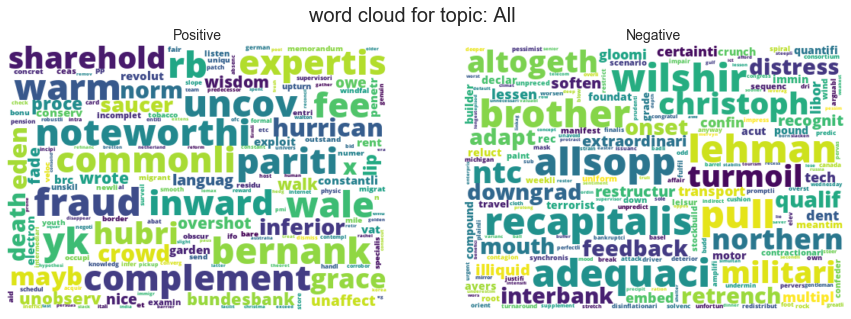

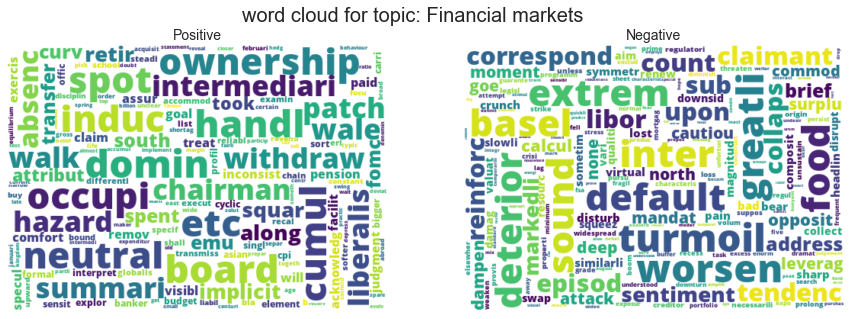

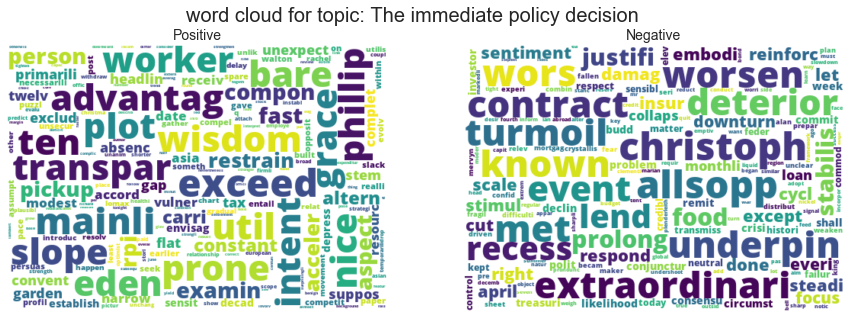

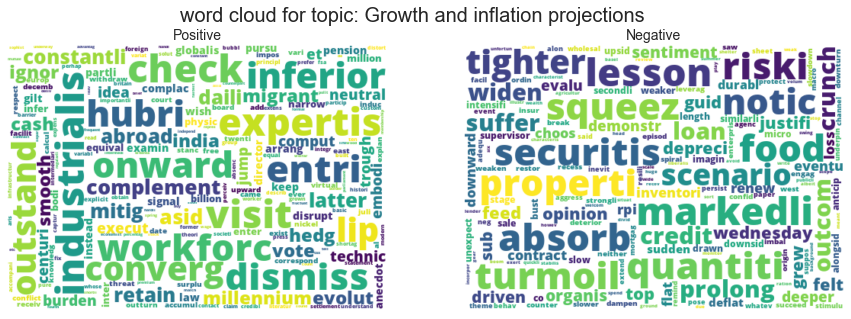

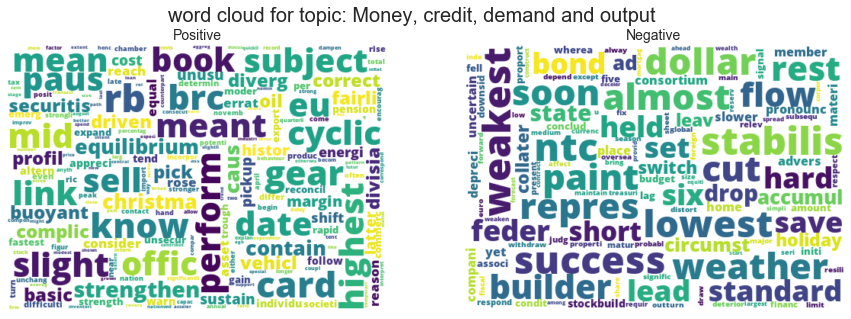

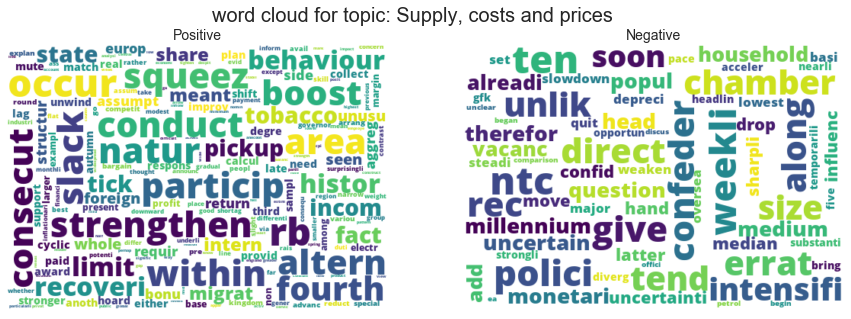

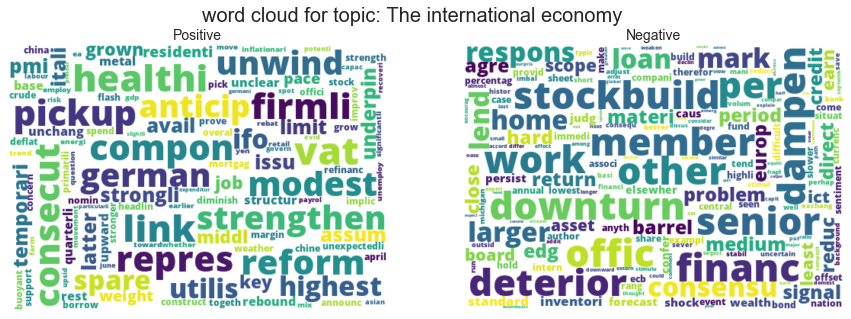

In [279]:
create_dictionary_visualisation(word_document_frequency_97_15_merged,para)

In [283]:
dictionary_model_97_15_merged[1]
# spacy

Entry sentiment
0     trough  Positive
1        vat  Positive
2    pension  Positive
3    rebound  Positive
4     tucker  Positive
..       ...       ...
307     weak  Negative
308    worri  Negative
309     wors  Negative
310   worsen  Negative
311    worst  Negative

[312 rows x 2 columns]